### Instalar e importar librerías

In [138]:
%pip install pandas seaborn nltk scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import normalized_mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import BaggingClassifier

### Importar, explorar y limpiar Dataset

In [140]:
df = pd.read_csv('Emotion_final.csv', sep=',', encoding='utf-8')
df.head(10)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,happy
9,i feel romantic too,love


#### Exploración de los datos

In [ ]:
#Saber la cantidad de filas, emociones únicas y si existen filas con valores nulos
print(df.describe(), '\n')
print(df.isna().sum())

                                                     Text Emotion
count                                               21459   21459
unique                                              21405       6
top     i feel more adventurous willing to take risks ...   happy
freq                                                    2    7029 

Text       0
Emotion    0
dtype: int64


[Text(0.5, 1.0, 'Balance de categorías')]

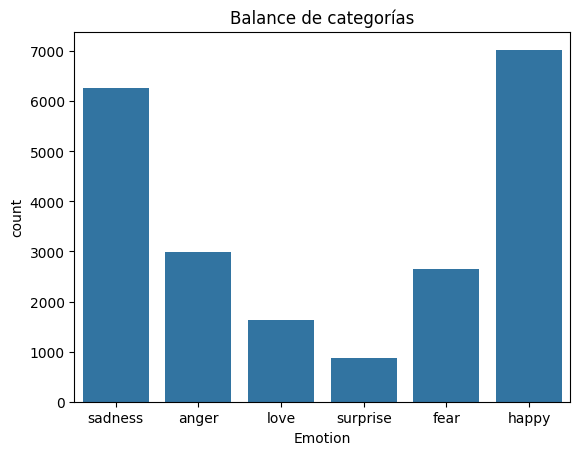

In [ ]:
#visualizar un countplot de las categorías para determinar el balance del dataset
sns.countplot(x=df['Emotion']).set(title="Balance de categorías")

### Procesar Texto

In [ ]:
nltk.download('stopwords') #descarga las palabras vacias
stemmer = PorterStemmer() #instanciar el stemmer
stop_words = set(stopwords.words('english')) #determinar las stopwords en ingles

def procesar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r' http\S+| www\S+| href\S+| src\S+', '', texto) #elimina enlaces
    texto = re.sub(r' http+| www+| href+| src+', '', texto) #elimina palabras sin sentido de enlaces
    texto = re.sub(r'@[\w]+','', texto) #elimina menciones de usuario
    texto = re.sub(r'#\w+','', texto) #elimina hashtags
    texto = re.sub(r'[^a-záéíóúüñ\s]','', texto) #elimina palabras tildadas o caracteres especiales
    
    words = texto.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    processed_texto = ' '.join(words)
    return processed_texto

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Play\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
df["texto_procesado"] = df['Text'].apply(procesar_texto)
df

,Text,Emotion,texto_procesado
0,i didnt feel humiliated,sadness,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,feel grouchi
...,...,...,...
21454,Melissa stared at her friend in dism,fear,melissa stare friend dism
21455,Successive state elections have seen the gover...,fear,success state elect seen govern parti pummel d...
21456,Vincent was irritated but not dismay,fear,vincent irrit dismay
21457,Kendall-Hume turned back to face the dismayed ...,fear,kendallhum turn back face dismay coup


In [145]:
target_idx = []
target_emotions = []
for idx, emocion in enumerate(df['Emotion'].unique()):
    target_idx.append(idx)
    target_emotions.append(emocion)

print(target_idx)
print(target_emotions)

df['Target'] = df['Emotion'].apply(lambda emotion: target_emotions.index(emotion))
df

[0, 1, 2, 3, 4, 5]
['sadness', 'anger', 'love', 'surprise', 'fear', 'happy']


,Text,Emotion,texto_procesado,Target
0,i didnt feel humiliated,sadness,didnt feel humili,0
1,i can go from feeling so hopeless to so damned...,sadness,go feel hopeless damn hope around someon care ...,0
2,im grabbing a minute to post i feel greedy wrong,anger,im grab minut post feel greedi wrong,1
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalg fireplac know still properti,2
4,i am feeling grouchy,anger,feel grouchi,1
...,...,...,...,...
21454,Melissa stared at her friend in dism,fear,melissa stare friend dism,4
21455,Successive state elections have seen the gover...,fear,success state elect seen govern parti pummel d...,4
21456,Vincent was irritated but not dismay,fear,vincent irrit dismay,4
21457,Kendall-Hume turned back to face the dismayed ...,fear,kendallhum turn back face dismay coup,4


### Dividir el set y Vectorizar

In [ ]:
# vectorizer = CountVectorizer(max_features = 10000)
# vectorizer.fit(df["texto_procesado"])
# X_train, X_test, y_train, y_test = train_test_split(df[["texto_procesado"]], df["Emotion"], test_size=0.25, random_state=42)
# X_train_counts = vectorizer.transform(X_train["texto_procesado"])
# X_test_counts = vectorizer.transform(X_test["texto_procesado"])
# X_train_counts


vectorizador = TfidfVectorizer(max_features = 10000) #instanciar el vectorizador con un max de 10K features/palabras
vectorizador.fit(df['texto_procesado']) #entrenar el vectorizador con el texto procesado
X_train, X_test, y_train, y_test = train_test_split(df[["texto_procesado"]], df["Target"], test_size=0.20, random_state=42) #dividir el dataset
X_train_counts = vectorizador.transform(X_train["texto_procesado"]) #vectorizar el set de entrenamiento
X_test_counts = vectorizador.transform(X_test["texto_procesado"]) #vectorizar el set de testeo 
X_train_counts #ver el tamano del set de entrenamiento

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 150439 stored elements and shape (17167, 10000)>

### Realizar sobremuestreo

Debido a que las clases están desbalanceadas, se realiza sobremuestreo al set de entrenamiento mediante SMOTE.
SMOTE genera nuevas muestras para las clases con pocas instancias, no duplicándolas, sino creando variaciones a partir de las existentes.

In [147]:
X_train_dense = X_train_counts.toarray() #convierte la matriz a una de formato aceptable para el smote

In [148]:
print(X_train_dense)
print("Tamaño del set de entrenamiento: ", len(X_train_dense))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Tamaño del set de entrenamiento:  17167


In [149]:
smote = SMOTE(random_state=42) #inicializa el smote
X_resampled, y_resampled = smote.fit_resample(X_train_dense, y_train) #realiza el sobremuestreo
print("Nuevo tamaño del set de entrenamiento: ", len(X_resampled))

Nuevo tamaño del set de entrenamiento:  33888


[Text(0.5, 1.0, 'Nuevo balance de categorías')]

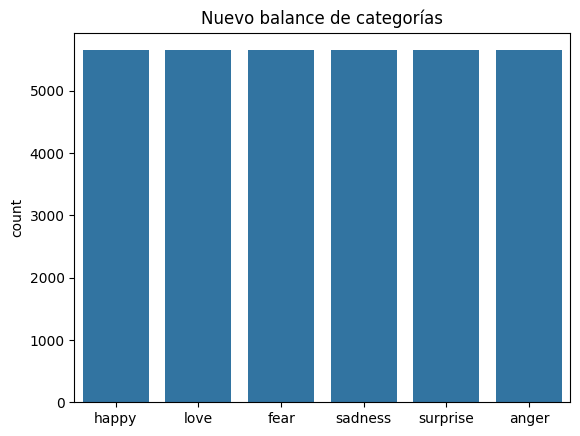

In [150]:

sns.countplot(x=[target_emotions[idx] for idx in list(y_resampled)]).set(title="Nuevo balance de categorías") #checkear el balance actual

### Evaluar Rendimiento

In [151]:
multiNB = MultinomialNB()

#Utilizando Cross validation
cv_results = cross_validate(multiNB, X_resampled, y_resampled, cv=4, scoring=['f1_weighted', 'accuracy'])
print("f1 prom: ", cv_results['test_f1_weighted'].mean())
print("Accuracy prom: ", cv_results['test_accuracy'].mean())

f1 prom:  0.9022703821591067
Accuracy prom:  0.9032991029272899


### Realizar Predicciones

In [152]:
multiNB = MultinomialNB()
multiNB.fit(X_resampled, y_resampled)
y_pred_multiNM = multiNB.predict(X_test_counts)
print(classification_report(y_test, y_pred_multiNM, target_names=target_emotions))

              precision    recall  f1-score   support

     sadness       0.89      0.86      0.87      1277
       anger       0.85      0.80      0.82       617
        love       0.59      0.79      0.68       318
    surprise       0.53      0.73      0.61       168
        fear       0.81      0.79      0.80       531
       happy       0.87      0.82      0.84      1381

    accuracy                           0.82      4292
   macro avg       0.76      0.80      0.77      4292
weighted avg       0.83      0.82      0.82      4292



### Evaluar reducir dimensionalidad

In [ ]:
mi = mutual_info_classif(X_train_counts, y_train) #mutual information

feature_names = np.array(vectorizador.get_feature_names_out()) #obtiene los labels de las emociones
mi_series = pd.Series(mi, index=feature_names)

c:\Users\Play\Documents\Tareas\RedditEmociones\txtEmotions\env\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
c:\Users\Play\Documents\Tareas\RedditEmociones\txtEmotions\env\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
c:\Users\Play\Documents\Tareas\RedditEmociones\txtEmotions\env\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
c:\Users\Play\Documents\Tareas\RedditEmociones\txtEmotions\env\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarni

feel      1.449200
like      0.255247
im        0.200093
get       0.086705
time      0.086272
            ...   
folk      0.002483
charm     0.002480
servic    0.002478
grief     0.002475
travel    0.002468
Length: 1000, dtype: float64

In [ ]:

mi_series = mi_series.sort_values(ascending=False).head(5000) #conservar los 5000 features (palabras) que aportan más información

In [ ]:
#se realiza la vectorización igual que antes
cv = TfidfVectorizer(vocabulary=mi_series.index)
cv.fit(X_train["texto_procesado"])

X_train_counts = cv.transform(X_train["texto_procesado"])
X_test_counts = cv.transform(X_test["texto_procesado"])

Tamaño del set de entrenamiento:  17167
Nuevo tamaño del set de entrenamiento:  33888


[Text(0.5, 1.0, 'Nuevo balance de categorías')]

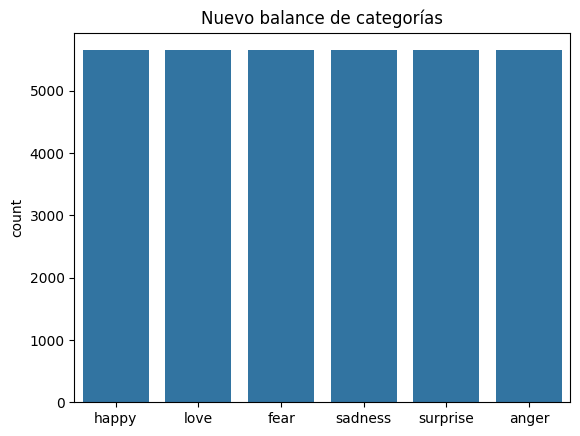

In [ ]:
#se realiza el sobremuestreo igual que antes
X_train_dense = X_train_counts.toarray() #convierte la matriz a una de formato aceptable para el smote
print("Tamaño del set de entrenamiento: ", len(X_train_dense))
smote = SMOTE(random_state=42) #inicializa el smote
X_resampled, y_resampled = smote.fit_resample(X_train_dense, y_train) #realiza el sobremuestreo
print("Nuevo tamaño del set de entrenamiento: ", len(X_resampled))
sns.countplot(x=[target_emotions[idx] for idx in list(y_resampled)]).set(title="Nuevo balance de categorías") #checkear el balance actual

In [ ]:
#cross validate igual que antes para ver cómo se ha visto afectado el rendimiento del modelo

multiNB = MultinomialNB()

#utilizando Cross validation
cv_results = cross_validate(multiNB, X_resampled, y_resampled, cv=4, scoring=['f1_weighted', 'accuracy'])
print("f1 prom: ", cv_results['test_f1_weighted'].mean())
print("Accuracy prom: ", cv_results['test_accuracy'].mean())

f1 prom:  0.8998742677634344
Accuracy prom:  0.9007908404154863


In [ ]:
#comprobar que efectivamente se mantienen 5000 features
print(len(X_resampled[0]))

5000


In [ ]:
#se realiza la prediccion igual que antes para ver el impacto
multiNB = MultinomialNB()
multiNB.fit(X_resampled, y_resampled)
y_pred_multiNM = multiNB.predict(X_test_counts)
print(classification_report(y_test, y_pred_multiNM, target_names=target_emotions))

              precision    recall  f1-score   support

     sadness       0.89      0.86      0.87      1277
       anger       0.84      0.80      0.82       617
        love       0.61      0.77      0.68       318
    surprise       0.54      0.73      0.62       168
        fear       0.79      0.79      0.79       531
       happy       0.87      0.82      0.85      1381

    accuracy                           0.82      4292
   macro avg       0.76      0.80      0.77      4292
weighted avg       0.83      0.82      0.82      4292



### Realizar Bagging

Con la esperanza de ver si es posible mejorar el rendimiento de la clasificación, se hace Bagging

In [ ]:
bagMultiNB = BaggingClassifier(estimator=MultinomialNB(), n_estimators=21, random_state=42).fit(X_resampled, y_resampled)


In [ ]:
print(classification_report(y_test, bagMultiNB.predict(X_test_counts), target_names=target_emotions))

              precision    recall  f1-score   support

     sadness       0.89      0.86      0.87      1277
       anger       0.84      0.81      0.82       617
        love       0.59      0.78      0.67       318
    surprise       0.53      0.73      0.61       168
        fear       0.79      0.79      0.79       531
       happy       0.88      0.82      0.85      1381

    accuracy                           0.82      4292
   macro avg       0.75      0.80      0.77      4292
weighted avg       0.83      0.82      0.82      4292

